In [15]:
import scipy
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from control import dare
import single_photons.utils.constants as ct
from single_photons.utils.parameters import *
from single_photons.environment import Cavity_Particle
from single_photons.simulation.simulation_cavity import simulation_c

In [98]:
def compute_phonons(estimations, cov_matrix, step=100):
    estimates = estimations[::control_step]
    sampled_cov_matrix = [el[0:,0:] for el in cov_matrix[:estimates.shape[0]]]
    N = len(sampled_cov_matrix)
    phonons = np.zeros((int(estimates.shape[0]/step)-1))
    for i in range(1, int(estimates.shape[0]/step)):
        averaged = estimates[(i-1)*step:i*step, 0:].mean(axis=0)
        second_moments = sampled_cov_matrix[i]+np.power(averaged,2)
        phonons[i-1] = np.trace(second_moments)/4-0.5
    
    low_crop = int((pulse_center - max([200*pulse_width,period])/(step*control_step))
    high_crop = int((pulse_center + max([200*pulse_width,period])/(step*control_step))
    crop_phonons = phonons[low_crop:high_crop]
    size = crop_phonons.shape[0]
    start_ref = int(300*period/(delta_t*step*control_step))
    reference = phonons[start_ref:size + start_ref]
    SNR = np.power(np.std(crop_phonons)/np.std(reference),2)
    
    plt.plot(1e3*t[::control_step][::step][1000:phonons.shape[0]],phonons[1000:])
    plt.ylabel('Phonons')
    plt.xlabel('Time [ms]')
    plt.figure()
    plt.plot(1e3*t[::control_step][::step][low_crop:high_crop],crop_phonons)
    plt.title('Crop around pulse')
    plt.ylabel('Phonons')
    plt.xlabel('Time [ms]')
    plt.figure()
    plt.title('Reference')
    plt.ylabel('Phonons')
    plt.xlabel('Time [ms]')
    plt.plot(1e3*t[::control_step][::step][start_ref:start_ref+size],reference)
    return [phonons, SNR]

def compute_optical_input(alpha_in, env, delta_t, N):
    x_in = (
    np.sqrt(env.__kappa__)
    * delta_t
    * (
        env.__optical_noise__ * np.random.normal() / np.sqrt(delta_t)
        + np.conjugate(alpha_in)
        + alpha_in
    )
    )
    y_in = (
        1j
        * np.sqrt(env.__kappa__)
        * delta_t
        * (
            env.__optical_noise__ * np.random.normal() / np.sqrt(delta_t)
            + np.conjugate(alpha_in)
            - alpha_in
        )
    )
    optical_input = 1j*np.zeros((4, N))
    optical_input[0, :] = x_in
    optical_input[1, :] = y_in    
    return optical_input

SyntaxError: invalid syntax. Perhaps you forgot a comma? (4163002476.py, line 11)

In [120]:
omega = 2*np.pi*1e5
period = 2*np.pi/omega
t = np.arange(0, 1000*period, period/2000)
delta_t = np.diff(t)[0]
N = t.shape[0]

rho = 2200
index_refraction = 1.4440
T = 293
p = 1e-6
radius = 75e-9
wavelength = 1.064e-6
power = 300e-3
waist = 1e-6
eta_detection = 0.178
control_step = int(30e-9/delta_t) 
fs = 1/(control_step*delta_t)
cavity_waist = 100e-6
cavity_length = 50e-3
tweezer_waist = 0.6e-6
detuning_ratio = 0.25 
cavity_linewidth_ratio = 0.5
optomechanical_coupling_ratio = 1.5 #with respect to g_0 defined below

gamma, omega, ba_force, std_detection, std_z, g_cs, detuning, cavity_linewidth =\
compute_parameters_simulation_cavity(power, wavelength, tweezer_waist, radius, p, fs, eta_detection, 
                                     cavity_length, cavity_waist, detuning_ratio, cavity_linewidth_ratio,
                                    T = T, rho = rho, index_refraction = index_refraction)

coupling = (1/(4*np.pi))*(ba_force**2)
g_0 = 0.19*omega

env = Cavity_Particle(
    omega,
    gamma,
    detuning,
    cavity_linewidth,
    optomechanical_coupling_ratio*g_0,
    coupling,
    radius=radius,
    eta_detection=eta_detection,
    T=T
)
variance_process = env.thermal_force_std**2 + env.backaction_std**2
std_detection = std_detection/env.zp_x

In [121]:
pulse_amplitude = 1
pulse_center = 5000+int(t.shape[0]/2)
round_trip_time = 2*cavity_length/ct.c
#https://www.rp-photonics.com/q_factor.html inverse of loss gives the average amount of round trips
trips = 1/(2*np.pi*round_trip_time*cavity_linewidth_ratio*omega)
pulse_width = trips*round_trip_time/delta_t
alpha_in = pulse_amplitude/(np.sqrt(delta_t) * np.power(np.pi*pulse_width**2,1/4)) * (
    np.exp(-((np.arange(0,N,1)-pulse_center)/(2*pulse_width**2))**2)
)

optical_input = compute_optical_input(alpha_in,env,delta_t,N)

In [122]:
Q = np.array(
    [
        [(env.__optical_noise__**2)*cavity_linewidth, 0, 0, 0],
        [0, (env.__optical_noise__**2)*cavity_linewidth, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, variance_process],
    ]
)*control_step*delta_t/2
R = np.array([[np.power(std_detection, 2)]])

g_fb = 5*omega
Ad = scipy.linalg.expm(env.A *control_step*delta_t)
Bd = env.B * delta_t * control_step
cost_states = np.array([[omega/2, 0, 0, 0],
                        [0, omega/2, 0, 0],
                        [0, 0, omega/2, 0],
                        [0, 0, 0, omega/2]
                       ])
X, L, G_fb = dare(Ad, Bd, cost_states, omega/(g_fb**2))

In [123]:
x0 = 0
P0 = ct.kb*T/(ct.hbar*omega)
new_states, measured_states, estimated_states, cov_aposteriori, controls = simulation_c(
    env.A,
    env.B, 
    optical_input,
    env.thermal_force_std,
    env.backaction_std, 
    std_detection, 
    eta_detection,
    x0, 
    P0, 
    Ad, 
    Bd, 
    env.C, 
    env.G,
    G_fb,
    Q, 
    R, 
    delta_t, 
    control_step, 
    N
)

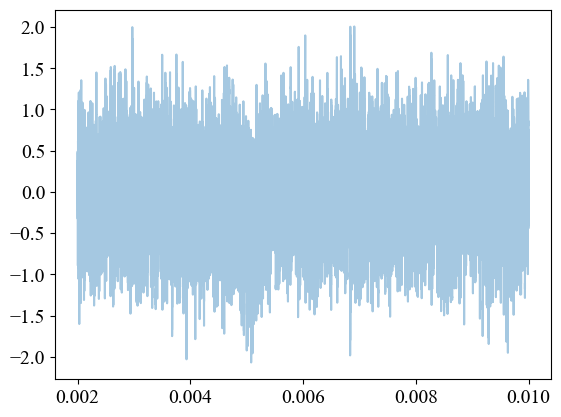

In [124]:
plt.plot(t[int(N/5):],estimated_states[int(N/5):,2],alpha = 0.4)

C:\Users\jorge\AppData\Local\Temp\ipykernel_8044\2606829814.py:9: ComplexWarning: Casting complex values to real discards the imaginary part
  phonons[i-1] = np.trace(second_moments)/4-0.5


22.330144109023767


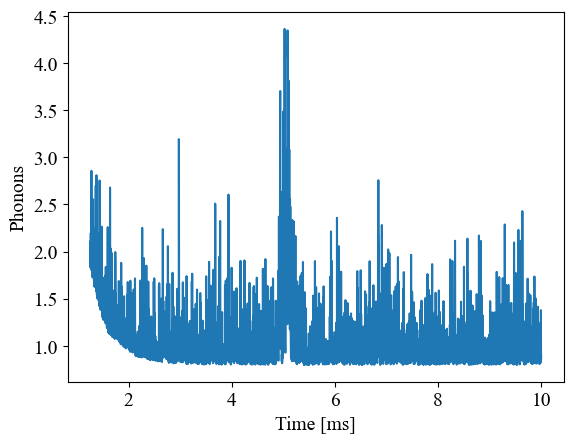

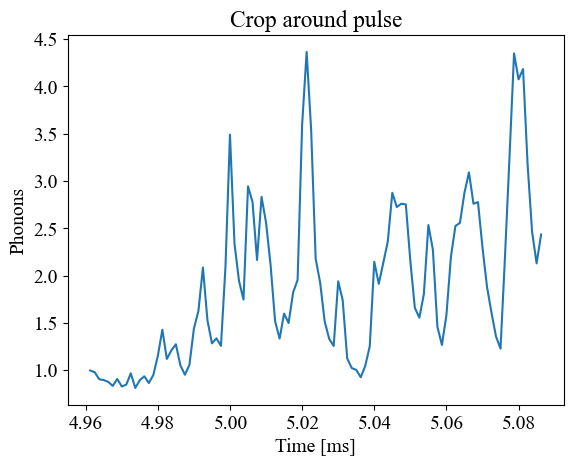

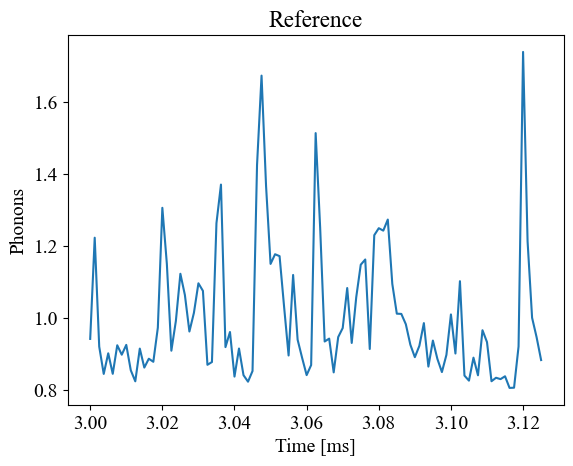

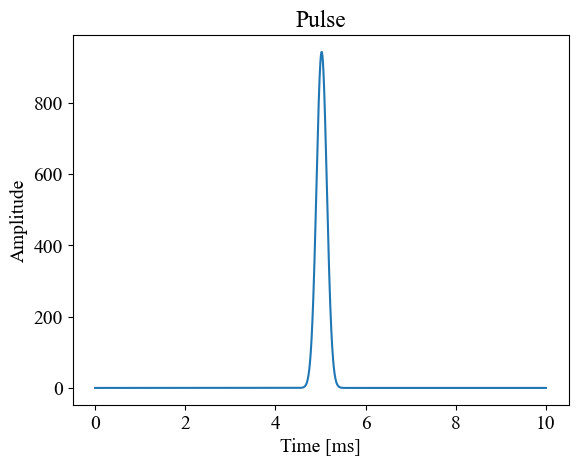

In [125]:
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 14

step = 50
phonons, SNR = compute_phonons(estimated_states,cov_aposteriori,step = step)
plt.figure()
plt.title('Pulse')
plt.plot(1e3*t,alpha_in)
plt.xlabel('Time [ms]')
plt.ylabel('Amplitude')
print(SNR)
#plt.plot(t[::control_step][::step][1001:],phonons[1000:], alpha = 0.4)
#plt.title('Phonons')
#plt.plot(t[::control_step][::step][1000:],phonons[1000:], alpha = 0.4)
#plt.plot(t[control_step*step*1000:],alpha_in[control_step*step*1000:]*10/max(alpha_in),alpha = 0.4)
#plt.figure()
#plt.plot(np.linspace(max(t)/5,max(t),len(SNR)),SNR)
#plt.title('SNR')

5e-09